## 演習②

### 顔画像データベースLFWのダウンロード

In [1]:
# Download LFW database
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-06-08 06:35:54--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  36.3MB/s    in 5.2s    

2022-06-08 06:36:00 (32.8 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



### LFWの解凍

In [2]:
# Extract a tgz file
import tarfile
file = tarfile.open('lfw.tgz', 'r:gz')
file.extractall()
file.close()

### 画像の確認

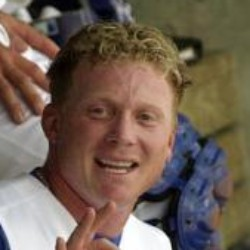

In [3]:
# Show one image from LFW
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('./lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg')
cv2_imshow(img)

### 顔検出のセットアップ

In [4]:
# Download the face detection model
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2022-06-08 06:36:46--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.04s   

2022-06-08 06:36:47 (24.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



### 正解データ

In [5]:
# Download
!wget https://raw.githubusercontent.com/yusuke-morishita/lecture/main/1/lfw_with_smile_label.txt

--2022-06-08 06:37:34--  https://raw.githubusercontent.com/yusuke-morishita/lecture/main/1/lfw_with_smile_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173816 (170K) [text/plain]
Saving to: ‘lfw_with_smile_label.txt’

lfw_with_smile_labe 100%[===================>] 169.74K  --.-KB/s    in 0.02s   

2022-06-08 06:37:34 (10.8 MB/s) - ‘lfw_with_smile_label.txt’ saved [173816/173816]



### 学習データの生成

In [6]:
# Using OpenCV
import cv2
# Using numpy
import numpy as np
# Using PyTorch
import torch
import torch.utils.data
# Using progress bar
from tqdm import tqdm

# Initialize a face detector by OpenCV
detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Read a file list
with open('lfw_with_smile_label.txt') as f:
    file_list = [s.strip().split() for s in f.readlines()]

    # Initialize a training data
    data_x = []
    data_y = []

    for filename, smile_label in tqdm(file_list):
        # Read one image from file list
        #print(filename, smile_label)
        img_bgr = cv2.imread(filename.replace('\\', '/'))
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = detector.detectMultiScale(img_gray)

        # Show detection results
        #for x, y, w, h in faces:
        #    cv2.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 0, 255), 2)
        #cv2.imshow('', img_bgr)
        #cv2.waitKey(0)

        # Create one norm image
        for x, y, w, h in faces:
            img_norm = cv2.resize(img_gray[y:y + h, x:x + w], dsize = (32, 32))
            data_x.append(img_norm)
            data_y.append(int(smile_label))
            #cv2.imshow('', img_norm)
            #cv2.waitKey(0)
            break

    # Create a training data
    data_x = np.expand_dims(np.array(data_x), axis = 1)  # (N,H=32,W=32)->(N,C=1,H=32,W=32)
    data_y = np.array(data_y)                            # (N,1)
    data_x = torch.tensor(data_x, dtype = torch.float32)
    data_y = torch.tensor(data_y, dtype = torch.int64)
    dataset = torch.utils.data.TensorDataset(data_x, data_y)
    # Save the training data
    torch.save(dataset, 'smile_dataset.pt')

100%|██████████| 3780/3780 [02:39<00:00, 23.65it/s]


### 画像認識（笑顔判定）モデルの学習：MLP

In [10]:
# Using PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# ===== Training params =====
# training parameters
num_epochs = 10
num_batch = 64
learning_rate = 0.001

# GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ===== Training Data  =====
# Load a training dataset
dataset = torch.load('smile_dataset.pt')
#print(len(dataset))

# Split the dataset: training (80%) / testing (20%)
n_dataset = len(dataset)
n_train = int(n_dataset * 0.8)
n_test = n_dataset - n_train
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

# Set a dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = num_batch, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = num_batch, shuffle = False)

# ===== Training model =====
# Define a nuural network model (MLP)
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32, 100),
            nn.Linear(100, 50),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.classifier(x)

# Define a nuural network model (MLP ver.2)
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.classifier(x)

# Create a neural network model
model = Net1().to(device)
#model = Net2().to(device)

# Set a loss function
criterion = nn.CrossEntropyLoss()
# Set an optimization method
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# ==== Training process ====
# Set training mode
model.train()

# Run training
for epoch in range(num_epochs):
    loss_sum = 0
    for inputs, labels in train_dataloader:
        # Flatten
        inputs = inputs.view(-1, 1*32*32)
        # Transfer data to GPU if needed
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Initialize the optimizer
        optimizer.zero_grad()
        # Process the NN model
        outputs = model(inputs)
        # Compute the loss value
        loss = criterion(outputs, labels)
        loss_sum += loss
        # Compute the gradient
        loss.backward()
        # Update weights
        optimizer.step()

    print(f"[Train] Epoch {epoch + 1}/{num_epochs}: Loss = {loss_sum.item() / len(train_dataloader)}")

    # Save the trained model
    torch.save(model.state_dict(), 'model_weights.pth')

# ====== Test process ======
# Set evaluation mode
model.eval()
loss_sum = 0
correct = 0

# Run evaluation
with torch.no_grad():
    for inputs, labels in test_dataloader:
        # Flatten
        inputs = inputs.view(-1, 1*32*32)
        # Transfer data to GPU if needed
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Process the NN model
        outputs = model(inputs)
        # Compute the loss value
        loss_sum += criterion(outputs, labels)
        # Retrieve the prediction value (1=smile or 0=neutral)
        prediction = outputs.argmax(1)
        # Count the number of correct predictions
        correct += prediction.eq(labels.view_as(prediction)).sum().item()

    print(f"[Test] Loss = {loss_sum.item() / len(test_dataloader)}, Accuracy: {100 * correct / len(test_dataset)}%")

[Train] Epoch 1/10: Loss = 22.838956197102863
[Train] Epoch 2/10: Loss = 0.5052612622578939
[Train] Epoch 3/10: Loss = 0.2892902692159017
[Train] Epoch 4/10: Loss = 0.32386086384455365
[Train] Epoch 5/10: Loss = 0.28134363889694214
[Train] Epoch 6/10: Loss = 0.24758917093276978
[Train] Epoch 7/10: Loss = 0.33290888865788776
[Train] Epoch 8/10: Loss = 0.2716156840324402
[Train] Epoch 9/10: Loss = 0.2607422471046448
[Train] Epoch 10/10: Loss = 0.22352186838785806
[Test] Loss = 0.2846860885620117, Accuracy: 88.59416445623341%


### 画像認識（笑顔判定）モデルの学習：LeNet

In [11]:
# Using PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# ===== Training params =====
# training parameters
num_epochs = 10
num_batch = 64
learning_rate = 0.001

# GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ===== Training Data  =====
# Load a training dataset
dataset = torch.load('smile_dataset.pt')
#print(len(dataset))

# Split the dataset: training (80%) / testing (20%)
n_dataset = len(dataset)
n_train = int(n_dataset * 0.8)
n_test = n_dataset - n_train
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

# Set a dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = num_batch, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = num_batch, shuffle = False)

# ===== Training model =====
# Define a nuural network model (LeNet)
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace = True),
            nn.Linear(120, 84),
            nn.ReLU(inplace = True),
            nn.Linear(84, 2)
        )

    def forward(self, x):
        return self.classifier(x)

# Create a neural network model
model = Net3().to(device)

# Set a loss function
criterion = nn.CrossEntropyLoss()
# Set an optimization method
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# ==== Training process ====
# Set training mode
model.train()

# Run training
for epoch in range(num_epochs):
    loss_sum = 0
    for inputs, labels in train_dataloader:
        # Transfer data to GPU if needed
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Initialize the optimizer
        optimizer.zero_grad()
        # Process the NN model
        outputs = model(inputs)
        # Compute the loss value
        loss = criterion(outputs, labels)
        loss_sum += loss
        # Compute the gradient
        loss.backward()
        # Update weights
        optimizer.step()

    print(f"[Train] Epoch {epoch + 1}/{num_epochs}: Loss = {loss_sum.item() / len(train_dataloader)}")

    # Save the trained model
    torch.save(model.state_dict(), 'model_weights.pth')

# ====== Test process ======
# Set evaluation mode
model.eval()
loss_sum = 0
correct = 0

# Run evaluation
with torch.no_grad():
    for inputs, labels in test_dataloader:
        # Transfer data to GPU if needed
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Process the NN model
        outputs = model(inputs)
        # Compute the loss value
        loss_sum += criterion(outputs, labels)
        # Retrieve the prediction value (1=smile or 0=neutral)
        prediction = outputs.argmax(1)
        # Count the number of correct predictions
        correct += prediction.eq(labels.view_as(prediction)).sum().item()

    print(f"[Test] Loss = {loss_sum.item() / len(test_dataloader)}, Accuracy: {100 * correct / len(test_dataset)}%")

[Train] Epoch 1/10: Loss = 0.40251608689626056
[Train] Epoch 2/10: Loss = 0.1849630872408549
[Train] Epoch 3/10: Loss = 0.14034277200698853
[Train] Epoch 4/10: Loss = 0.11224343379338582
[Train] Epoch 5/10: Loss = 0.09241804480552673
[Train] Epoch 6/10: Loss = 0.07450902462005615
[Train] Epoch 7/10: Loss = 0.060889417926470436
[Train] Epoch 8/10: Loss = 0.04290831585725149
[Train] Epoch 9/10: Loss = 0.038710748155911766
[Train] Epoch 10/10: Loss = 0.036738855143388115
[Test] Loss = 0.21974496046702066, Accuracy: 93.23607427055703%
